#  Unsupervised learning (PCA, K-Means)



### Importing necessary packages

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import read, show

%matplotlib inline

### Importing the data to form training and test sets 

(28, 28, 3133) (28, 28, 3132)


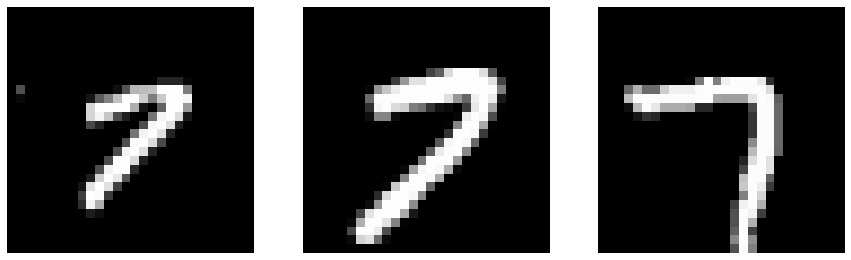

In [194]:
# Reads in the data from MNIST database
data = read() 

# Retrieve the entries corresponding to the digit 7
samples = []
for sample in data:
    if sample[0] == 7:
        samples.append(sample[1].astype(float))
        
# Stack images in a tensor of size 28x28xnb_images
samples = np.stack(samples,axis=2)

# Defines training and testing set
train_set = samples[:,:,:3133]
test_set = samples[:,:,3133:]
print(train_set.shape, test_set.shape)

# Plot some images 
fig, axes = plt.subplots(1,3,figsize=(15,100))
plt.rcParams['image.cmap'] = 'gray'
axes[0].imshow(train_set[:,:,1])
axes[1].imshow(train_set[:,:,100])
axes[2].imshow(train_set[:,:,1000])
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

# Transform the data for processing, i.e. unroll the 28x28 images in vectors of size (28*28)x1
X = np.reshape(train_set,(28*28,3133)).T
Y = np.reshape(test_set,(28*28,3132)).T


<a id='pca'></a>
## Principal Component Analysis

The data has now been initialised, everything is set to start on coding. 



In [195]:
def pca(X,n_components = None):
    
    # If no number of component is specified, the function keeps them all
    if n_components is None:
        n_components = X.shape[1]

    # Compute mean digit and shift the data
    X_mean = np.mean(X, axis = 0)
    X = X - X_mean
    # Compute covariance of the data
    cov = np.cov(X.T)
    # Compute the eigenvector of the covariance matrix
    _, eigenvector = np.linalg.eigh(cov)
    # Retrieve the eigenvectors to return
    components = eigenvector[:, -n_components:]

    # Returns the transformed data, the principal components, and the mean digit
    return X_mean, components

def pca_project(Y,X_mean,components):
    # Compute the projection of the input data on the selected components
    # Compute the expansion coefficients of the data
    reconstruction = (Y - X_mean) @ components @ components.T
    
    return X_mean + reconstruction 
    

(-0.5, 27.5, 27.5, -0.5)

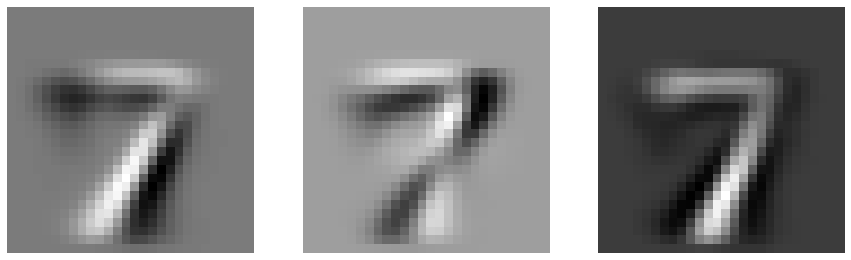

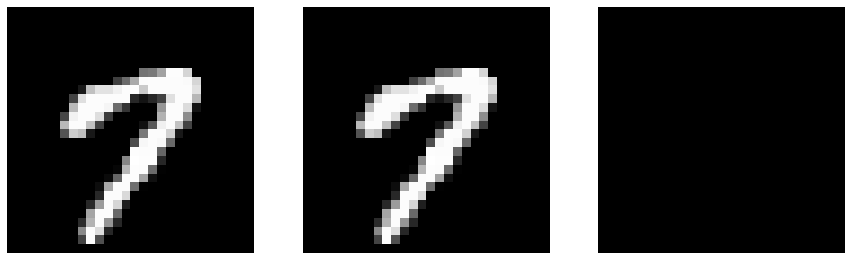

In [196]:
# This tests if your functions are correct, you should get the same output as we do
X_mean, components = pca(X,n_components=None)

# Reshapes the reconstructed data to have 28x28 pictures
comp_ = np.reshape(components,(28,28,784))

fig, axes = plt.subplots(1,3,figsize=(15,100))
plt.rcParams['image.cmap'] = 'gray'
axes[0].imshow(comp_[:,:,-1])
axes[1].imshow(comp_[:,:,-2])
axes[2].imshow(comp_[:,:,-3])
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

X_projected = pca_project(X,X_mean,components)

X_ = np.reshape(X_projected.T,(28,28,3133))
fig, axes = plt.subplots(1,3,figsize=(15,100))
plt.rcParams['image.cmap'] = 'gray'
axes[0].imshow(train_set[:,:,0])
axes[1].imshow(X_[:,:,0])
axes[2].imshow(train_set[:,:,0]-X_[:,:,0]>10**(-12))
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')

#### Testing PCA 


<a id='q2'></a>
Computation of the reconstruction error $E$ on the <b>testing set</b>, for a number of components varying from 1 to 100, as defined by: 
$$
E(D) = \frac{1}{N}\sum_{n=1}^N \|I_n - (\mathbf{\mu}+\sum_{k=1}^D \omega_k^n\mathbf{u}_k) \|_2,
$$
with $I_n$ denoting the $n$-th image of the testing set, $\mathbf{\mu}$ is the mean digit learnt from the training set, $\mathbf{u}_k$ is the eigenvector with the $k$-th largest eigenvalue, and $\omega_k^n$ is the expansion coefficient of the $n$-th image on the $k$-th eigenvector. Finally, $\|.\|_2$ denotes the $L_2$ norm. 


In [197]:
max_n_components = 100 # Max number of components to keep

xrange = range(1,max_n_components+1)
error = []


# Compute the Error for n_components between 1 and 100
for i in xrange:
    mean, comp = pca(X, i)
    error_i = np.sum(np.linalg.norm(Y - pca_project(Y, mean, comp)) ,axis=0)/(Y.shape[0])
    error.append(error_i)
    


<a id='q3'></a>
Plot of the evolution of the error $E$ for $D = 1,\ldots,100$.

Text(0, 0.5, 'Error (D)')

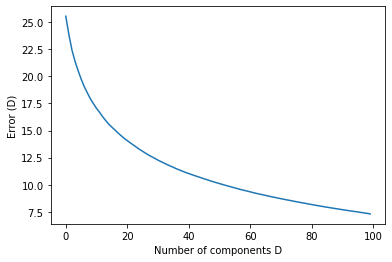

In [198]:



# Plot the error with respect to n_components
fig, ax = plt.subplots()
ax.plot(error)
ax.set_xlabel("Number of components D")
ax.set_ylabel("Error (D)")


<a id='kmeans'></a>
# K-Means


<a id='q4'></a>
Computation of the distortion cost $F$ for a given clustering of the data:
$$
F(m,c) = \frac{1}{N}\sum_{i=1}^N \|x^i - c^{m(i)}\|_2,
$$
where $N$ corresponds to the total number of images in the set and $m(i)$ denotes which cluster is assigned to the image $x^i$.<br/>

In [199]:
def distortion(X, cluster_assignment, centroids):
    
    n_cluster, n_variables = centroids.shape
    distortion = 0

    for i in range(X.shape[0]):
        distortion += np.linalg.norm(X[i] - centroids[cluster_assignment[i].astype(int)])
        
    return distortion/X.shape[0]

<a id='q5'></a>
Computation of the distortion after each update. 

In [200]:
import math
def assign_cluster(centroids, X):
    
    n_observations, _ = X.shape
    # Initialise cluster_assignment to -1
    cluster_assignment = -1*np.ones((n_observations,))
    
    for i in range(n_observations):
        min_distance = math.inf
        for j in range(centroids.shape[0]):
            if np.linalg.norm(X[i] - centroids[j], ord=2) < min_distance:
                min_distance = np.linalg.norm(X[i] - centroids[j], ord=2)
                cluster_assignment[i] = j

    return cluster_assignment

def kmeans(X, n_clusters = 2, max_iter =1000, tol = 10**-10, verbose = False):
    
    n_observations, n_variables = X.shape
    
    # Randomly initialise the centroids using the multivariate gaussian computed from the data
    X_mean = np.mean(X,axis=0)
    X_cov = np.cov(X,rowvar=False)
    centroids = np.random.multivariate_normal(X_mean,X_cov,(n_clusters,))
    
    n_iter = 0
    distortion_scores = []
    # Loop as long as the number of iterations is below max_iter and if the converging criteria has not be met
    while (n_iter < max_iter):
        n_iter += 1
        # Step 1: assign points to nearest center
        cluster_assignment = assign_cluster(centroids, X)
        
        # Step 2: compute distortion
        dist = distortion(X, cluster_assignment, centroids)
        distortion_scores.append(dist)
        if verbose:
            print("Iteration %s, distortion = %s" % (n_iter,dist))
              
        # Step 3: compute new centroids from the clusters
        new_centroids = np.zeros(centroids.shape)
        for j in range(n_clusters):
            try:
                new_centroids[j] = sum(X[np.argwhere(cluster_assignment == j)])/X[np.argwhere(cluster_assignment == j)].shape[0]
            except ZeroDivisionError:
                new_centroids[j] = sum(X[np.argwhere(cluster_assignment == j)])
            
        # Step 4: break the loop if difference between previous centroids and new ones is small enough
        if np.linalg.norm(new_centroids-centroids)<tol:
            if verbose:
                print("Terminates with difference: %s\n" % np.linalg.norm(new_centroids-centroids))
            break
        else:
            centroids = new_centroids
    
    return cluster_assignment, centroids, distortion_scores

In [201]:

np.random.seed(11) # Ensures a consistent initialization

cluster_assignment, centroids, distortion_scores = kmeans(X,verbose=True)

Iteration 1, distortion = 2090.693634653865
Iteration 2, distortion = 1452.1080032615912
Iteration 3, distortion = 1447.3234304404755
Iteration 4, distortion = 1445.8312662101594
Iteration 5, distortion = 1444.8075361050326
Iteration 6, distortion = 1444.1405173480803
Iteration 7, distortion = 1443.7409894089387
Iteration 8, distortion = 1443.5609163489976
Iteration 9, distortion = 1443.4633567689327
Iteration 10, distortion = 1443.4029019077504
Iteration 11, distortion = 1443.365125904968
Iteration 12, distortion = 1443.3344999721169
Iteration 13, distortion = 1443.284897951173
Iteration 14, distortion = 1443.267950454885
Iteration 15, distortion = 1443.2627485947248
Terminates with difference: 0.0



In [172]:
# Helper function to plot multiple images (non-graded)
def plot_kmeans(centroids, n = 4):
    
    k = centroids.shape[0]
    m = int(np.ceil(k/n))
    fig, axes = plt.subplots(m,n,figsize=(n*5,m*5))
    plt.rcParams['image.cmap'] = 'gray'
    for c in range(k):
        if m == 1:
            axes[c].imshow(np.reshape(centroids[c,:],(28,28)))
            axes[c].axis('off')
        else:
            i, j = int(c/n), int(c - i*n)
            axes[i,j].imshow(np.reshape(centroids[c,:],(28,28)))
            axes[i,j].axis('off')
            
    for c in range(k,m*n):
        if m == 1:
            axes[c].remove()
            axes[c].axis('off')
        else:
            i, j = int(c/n), int(c - i*n)
            axes[i,j].remove()
            axes[i,j].axis('off')
    

#### Testing K-means

<a id='q6'></a>
 In order to mitigate the local minima problem of K-Means, the following code repeats the algorithm 10 times, and keeps the solution that yields the smallest distortion at the end. 

Run k=2: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 


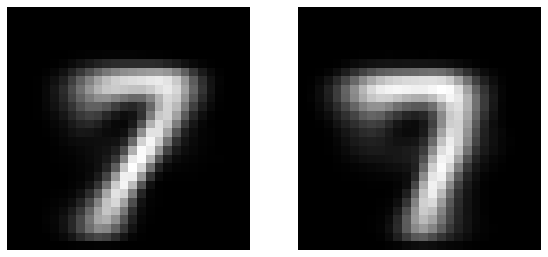

In [173]:
def select_clustering(X,k=2,repeats=10):
    # Returns clustering with lowest distortion across "repeats" number of runs
    clustering = None
    print("Run k=%s:" % k,end=' ')
    
    min_dist = math.inf
    for i in range(repeats):
        print("%s/%s.." % (i+1,repeats), end=' ')
        np.random.seed(i) # Do not change this line, it insures you get the same random initialisation as us
        
        # Compute clusters and retrieve the one with lowest distortion
        cluster_assignment, centroid, distortions = kmeans(X,n_clusters=k,verbose=False)
        if distortions[-1] < min_dist:
            clustering = [cluster_assignment, centroid, distortions]
            min_dist = np.min(distortions)
            
    print("\n",end='')
    return clustering

clustering = select_clustering(X)

# Plot the centres of the clusters
plot_kmeans(clustering[1])

<a id='q7'></a>
Repeats the procedure for values of $k = 3,4,5,10,50,100$ (~10min). Plot of the evolution of the distortion cost of the training and testing data:

In [174]:
train_distortions = []
test_distortions = []

ks = [2,3,4,5,10,50,100]

for i in ks:
    clustering = select_clustering(X, k=i)
    train_distortions.append(np.min(clustering[2]))
    test_assign_cluster = assign_cluster(clustering[1], Y)
    test_distortions.append(np.min(distortion(Y, test_assign_cluster, clustering[1])))

Run k=2: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=3: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=4: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=5: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=10: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=50: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 
Run k=100: 1/10.. 2/10.. 3/10.. 4/10.. 5/10.. 6/10.. 7/10.. 8/10.. 9/10.. 10/10.. 


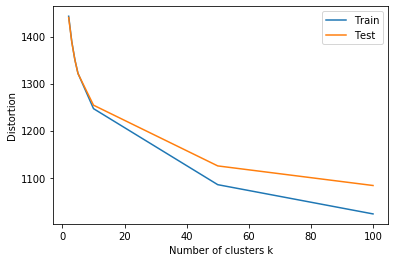

In [175]:
# Plotting the evolution of distortion for train and test set
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(ks,np.array(train_distortions))
ax.plot(ks,np.array(test_distortions))

plt.xlabel("Number of clusters k")
plt.ylabel("Distortion")
plt.legend(['Train', 'Test'])

<a id='comparison'></a>
# Comparison

<a id='q8'></a>
Comparison of the results from PCA to the results of K-means on the <b>test set</b> by plotting on the same graph the reconstruction error $E(D)$ for $D = 3,4,5,10,50,100$ and the distortion cost you just computed (remark that the two measures are simply L$_2$ norms thus the comparison is valid). To be clear, the first one measure the error in the reconstructed image from the projection on the components of PCA, the second measure the error between each image and the centroid of the cluster it is assigned to. Both correpond to the error made when approximating the original image to either its projection or its cluster's centroid.

In [176]:
# No need to recompute kmeans here, just compute PCA for the corresponding values of k 

n_components = [2,3,4,5,10,50,100] # Max number of components to keep
error = []

for i in n_components:
    X_mean, eg = pca(X, i)
    Y_projected = pca_project(Y, X_mean, eg)
    err = Y - Y_projected
    error_i =  np.sum(np.linalg.norm(err, axis=1))/len(Y)
    error.append(error_i)

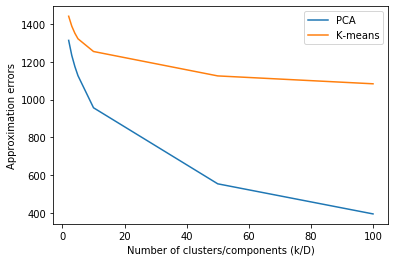

In [177]:
# Plotting the comparison

fig = plt.figure()
plt.plot(n_components, error, label="K-means")
plt.plot(n_components, test_distortions, label="PCA")
plt.xlabel("Number of clusters/components (k/D)")
plt.ylabel("Approximation errors")
plt.legend(['PCA', 'K-means'])